# I) General

## 1. Importations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import codecs
import re
import os.path
import random
import string
import re
import unicodedata
from time import time
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import sklearn.naive_bayes as nb
from sklearnex import patch_sklearn
patch_sklearn() # Should speed up learning somehow 

from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# II) First data set french presidents

## 1. Data visualization

In [2]:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8')
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs

In [3]:
def preprocessing(X):
    res = []
    for doc in X:
        punc = string.punctuation
        punc += '\n\r\t'
        doc = doc.translate(str.maketrans(punc, ' ' * len(punc)))
        doc = unicodedata.normalize('NFD', doc).encode('ascii', 'ignore').decode("utf-8")
        doc = doc.lower()
        doc = re.sub('[0-9]+', '', doc)
        res.append(doc)
    return np.array(res)

def formal(X):
    stemmer = SnowballStemmer(language='french')
#     nltk.download('stopwords')
    res = []
    stop = stopwords.words('french')
    for doc in X:
        new_doc = ""
        for w in doc.split():
            if w not in stop:
                new_doc += w + " "
        new_doc = [stemmer.stem(X) for X in new_doc.split()]
        new_doc = " ".join(new_doc)
        res.append(new_doc)
    return res

def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): 
            rt.extend(flatten(i))
        else: 
            rt.append(i)
    return rt

In [4]:
def result_for_pandas(vectorizer,clf,X_train,X_test,Y_train,Y_test,windows=10,threshold=0.5):
#def result_for_pandas(vectorizer,final,X_train_final,X_test_final,Y_train_final,Y_test_final):
    #X_final_vector = vectorizer.fit_transform(X_train_final)
    #X_test_vector = vectorizer.transform(X_test_final)
    #final.fit(X_final_vector,  Y_train_final)
    #grid_predictions = final.predict(X_test_vector)
    
    X_train_2 = vectorizer.fit_transform(X_train,y_train)
    X_test_2 = vectorizer.transform(X_test)

    #clf = sv.LinearSVC(C=100, class_weight="balanced")
    X_train_3 = clf.fit(X_train_2,y_train)
    y_pred = clf.predict(X_test_2)
    #y_pred = final_postprocessing(y_pred, windows, threshold)
    #classification_report(y_test,y_pred)
    #return classification_report(Y_test_final, grid_predictions,output_dict=True),X_final_vector
    return classification_report(y_test, y_pred,output_dict=True),X_train_2


def result_for_graphic_min_max_df(liste_x,liste_y,final,X_train_final,X_test_final,Y_train_final,Y_test_final,dico_param,windows=10,threshold=0.5):
    result = []
    f1_score_0 = 0.;f1_score_1=0.;recall_0= 0.;recall_1= 0.;precision_0= 0.;precision_1= 0.;nb_mot= 0.
    
    for i in liste_x:
        temps = []
        for j in liste_y:
            try :
                vectorizer_exp = TfidfVectorizer(
                    lowercase=dico_param["lowercase"],
                     stop_words=dico_param["stop_words"],
                     strip_accents=dico_param["strip_accents"],
                     # use_idf=dico_param["use_idf"],
                     # smooth_idf=dico_param["smooth_idf"],
                     #sublinear_tf=dico_param["sublinear_tf"],
                     max_features=dico_param["max_features"],
                     min_df=i,
                     max_df=j,
                     ngram_range=dico_param["ngram_range"],
                              )

                results,vect_temps = result_for_pandas(vectorizer_exp,final,X_train_final,X_test_final,Y_train_final,Y_test_final,windows=10,threshold=0.5)
                pds = pd.DataFrame(results)
                f1_score_0 = pds.loc["f1-score"]["-1"]
                f1_score_1 = pds.loc["f1-score"]["1"]
                recall_0 = pds.loc["recall"]["-1"]
                recall_1 = pds.loc["recall"]["1"]
                precision_0 = pds.loc["precision"]["-1"]
                precision_1 = pds.loc["precision"]["1"]
                nb_mot = vect_temps.shape[1]
                temps.append((f1_score_0,f1_score_1,recall_0,recall_1,precision_0,precision_1,nb_mot))
            except : #Case where max_df < min_df
                temps.append((f1_score_0,f1_score_1,recall_0,recall_1,precision_0,precision_1,nb_mot))
        result.append(temps)
    
    for i in range(len(result)) :
        for j in range(1,len(result[i])):
            if result[i][j] == 0.0 :
                result[i][j] = result[i][j-1]
    return np.array(result)

def display_min_max_df(liste_x,liste_y,result,nom_fichier):
    ind = 1
    plt.figure(figsize=(20,20))      
    for i,val in enumerate(result) :
        plt.subplot(4,4,ind)

        plt.plot(liste_y,np.array(result[i])[:,0],label=f"f1-score -1")
        plt.plot(liste_y,np.array(result[i])[:,1],label=f"f1-score 1")
        plt.plot(liste_y,np.array(result[i])[:,2],label=f"recall -1")
        plt.plot(liste_y,np.array(result[i])[:,3],label=f"recall 1")
        plt.plot(liste_y,np.array(result[i])[:,4],label=f"precision -1")
        plt.plot(liste_y,np.array(result[i])[:,5],label=f"precision 1")

        plt.title(f"Min_df = {liste_x[i]:.5f}")
        plt.xlabel("Max_df")
        plt.ylabel("Score") # based function Max_df
        plt.legend(bbox_to_anchor=(1.0,1.0),loc='upper left')
        ind += 1
    plt.savefig(nom_fichier)

def display_nb_mot_min_max_df(liste_x,liste_y,result,nom_fichier):
    ind = 1
    plt.figure(figsize=(20,20))      
    for i,val in enumerate(result) :
        plt.subplot(4,4,ind)
        plt.plot(liste_y,np.array(result[i])[:,-1],label=f"Nombre de mot")

        plt.title(f"Min_df = {liste_x[i]}.5f")
        plt.xlabel("Max_df")
        plt.ylabel("Nombre de mot") # based function Max_df
        plt.legend(bbox_to_anchor=(1.0,1.0),loc='upper left')
        ind += 1
    plt.savefig(nom_fichier)

def result_for_graphic_n_gram(liste_z,final,X_train_final,X_test_final,Y_train_final,Y_test_final,dico_param,windows=10,threshold=0.5):
    result_n_gram = []
    for n in liste_z:
        vectorizer_exp = TfidfVectorizer(
            lowercase=dico_param["lowercase"],
         stop_words=dico_param["stop_words"],
         strip_accents=dico_param["strip_accents"],
          #use_idf=dico_param["use_idf"],
          #smooth_idf=dico_param["smooth_idf"],
         #sublinear_tf=dico_param["sublinear_tf"],
         max_features=dico_param["max_features"],
         min_df=dico_param["min_df"],
         max_df=dico_param["max_df"],
         ngram_range=n,
         )
            
        results,vect_temps = result_for_pandas(vectorizer_exp,final,X_train_final,X_test_final,Y_train_final,Y_test_final,windows=10,threshold=0.5)
        pds = pd.DataFrame(results)
        f1_score_0 = pds.loc["f1-score"]["-1"]
        f1_score_1 = pds.loc["f1-score"]["1"]
        recall_0 = pds.loc["recall"]["-1"]
        recall_1 = pds.loc["recall"]["1"]
        precision_0 = pds.loc["precision"]["-1"]
        precision_1 = pds.loc["precision"]["1"]
        nb_mot = vect_temps.shape[1]
        result_n_gram.append((f1_score_0,f1_score_1,recall_0,recall_1,precision_0,precision_1,nb_mot))
    return np.array(result_n_gram)

def display_nb_mot_score_n_gram(liste_z,result_n_gram,nom_fichier):
    ind = 1
    plt.figure(figsize=(10,10))      
    for i,val in enumerate(result_n_gram) :
        plt.subplot(1,3,ind)
        plt.scatter(np.array(result_n_gram[i])[-1],np.array(result_n_gram[i])[0],label=f"f1-score -1")
        plt.scatter(np.array(result_n_gram[i])[-1],np.array(result_n_gram[i])[1],label=f"f1-score 1")
        plt.scatter(np.array(result_n_gram[i])[-1],np.array(result_n_gram[i])[2],label=f"recall -1")
        plt.scatter(np.array(result_n_gram[i])[-1],np.array(result_n_gram[i])[3],label=f"recall 1")
        plt.scatter(np.array(result_n_gram[i])[-1],np.array(result_n_gram[i])[4],label=f"precision -1")
        plt.scatter(np.array(result_n_gram[i])[-1],np.array(result_n_gram[i])[5],label=f"precision 1")

        plt.title(f"N-gram = {liste_z[i]}")
        plt.xlabel("N-gram")
        plt.ylabel("Score") 
        plt.legend(bbox_to_anchor=(1.0,1.0),loc='upper left')
        ind += 1
    plt.savefig(nom_fichier)
    
def display_graphic_analysis(dico_param,liste_x,liste_y,liste_z,final_model,X_train_final,X_test_final,Y_train_final,Y_test_final,name_data):
    result = result_for_graphic_min_max_df(liste_x,liste_y,final_model,X_train_final,X_test_final,Y_train_final,Y_test_final,dico_param)
    display_min_max_df(liste_x,liste_y,result,f'{name_data}_min_df_max_df_f1_score.png')
    display_nb_mot_min_max_df(liste_x,liste_y,result,f'{name_data}_min_df_max_df_nombre_mot.png')
    result_n_gram = result_for_graphic_n_gram(liste_z,final_model,X_train_final,X_test_final,Y_train_final,Y_test_final,dico_param)
    display_nb_mot_score_n_gram(liste_z,result_n_gram,f"{name_data}_n_gram_f1_score_nb_mot")

In [5]:
fname = "./data/corpus.tache1.learn.utf8"
alltxts,alllabs = load_pres(fname)

vectorizer = TfidfVectorizer(lowercase=False,
                                 stop_words=None,
                                 strip_accents=None,
                                 # use_idf=True,
                                 # smooth_idf=True,
                                 # sublinear_tf=False,
                             
                                 max_features=50_000,
                                 min_df=1,
                                 max_df=0.5,
                                 ngram_range=(1,2),
                                 )
clf = LinearSVC(class_weight="balanced",
                      max_iter=10_000,
                C=1.15)

X_train,X_test,y_train,y_test = train_test_split(alltxts,alllabs,test_size=0.33,random_state=1)
    
dico_param = {"lowercase":False,
     "stop_words":None,
     "strip_accents":None,
      #"use_idf":True,
      #"smooth_idf":False,
     #"sublinear_tf":True,
     "max_features":50_000,
     "min_df":1,
     "max_df":0.5,
     "ngram_range":(1,2)
    } #Param's optimal

liste_x = np.arange(1,32,2) #min_df
liste_y = np.linspace(0.01,1,16) #max_df
liste_z = [(1,1),(1,2),(2,2)] #n_gram

# display_graphic_analysis(dico_param,liste_x,liste_y,liste_z,clf,X_train,X_test,y_train,y_test,"president")

In [6]:
fname = "./data/corpus.tache1.learn.utf8"
alltxts, alllabs = load_pres(fname)
X = np.array(alltxts)[:1000]
Y = np.array(alllabs)[:1000]
X_preprocess = preprocessing(X)
X_train = formal(X_preprocess)

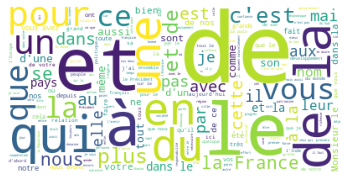

In [7]:
words = "".join(flatten(X))
wordcloud = WordCloud(background_color='white', max_words=200).generate(words)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

[9.99995000e-06 9.99995000e-06 9.99995000e-06 ... 6.56948143e+00
 6.72022017e+00 7.12689082e+00]
['insiste' 'malabar' 'malentendus' ... 'et' 'la' 'de']


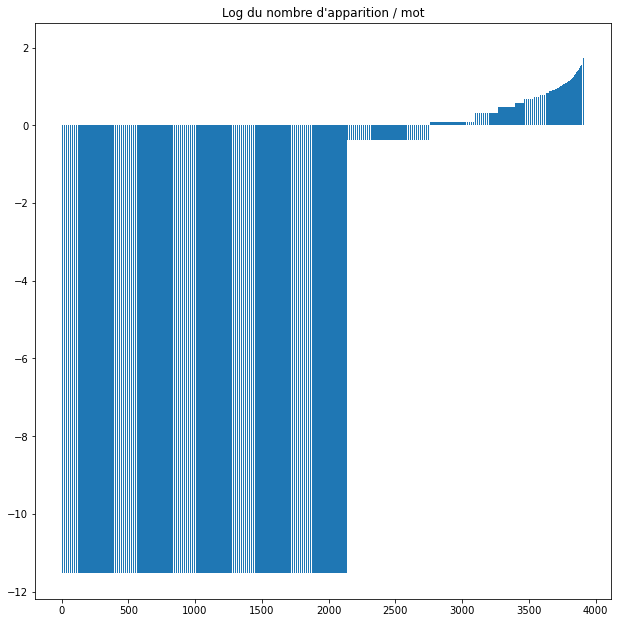

In [8]:
words = "".join(flatten(X_preprocess))
unique_words, count = np.unique(words.split(), return_counts=True)
count = np.log(count+1e-5)

count_sort_ind = np.argsort(count)
unique_words = unique_words[count_sort_ind]
count = np.sort(count)
print(count)
print(unique_words)

fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(len(count)),np.log(count))
plt.title("Log du nombre d'apparition / mot")
plt.show()

[   1    1    1 ...  713  829 1245]
['insiste' 'malabar' 'malentendus' ... 'et' 'la' 'de']


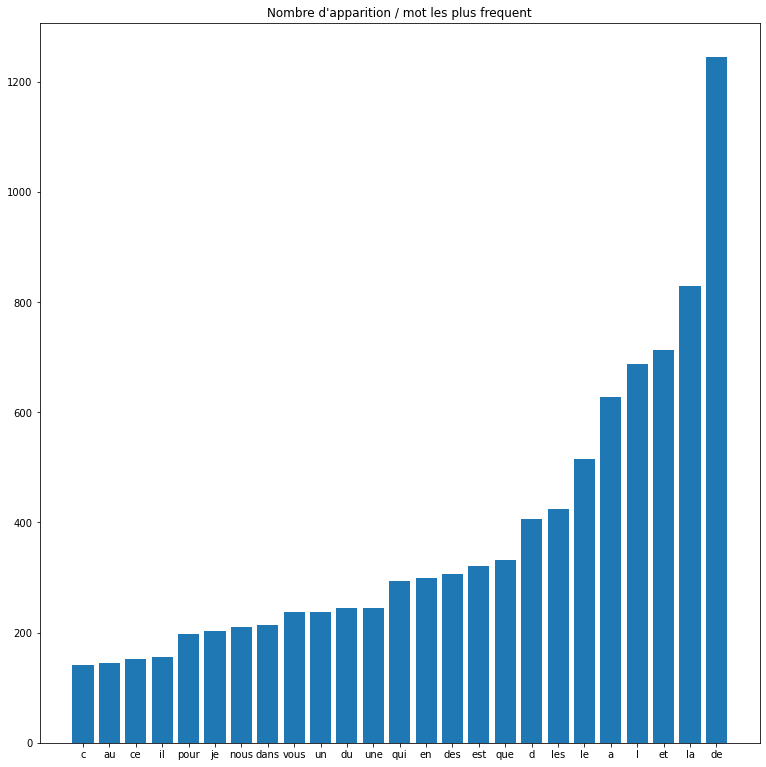

In [9]:
unique_words, count = np.unique(words.split(), return_counts=True)

count_sort_ind = np.argsort(count)
unique_words = unique_words[count_sort_ind]
count = np.sort(count)
print(count)
print(unique_words)

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
ax.bar(unique_words[len(count)-25:],count[len(count)-25:])
plt.title("Nombre d'apparition / mot les plus frequent")
plt.show()

## 2. Features and model selection

In [10]:
def naive_balancing(X, Y):
    label, count = np.unique(Y, return_counts=True)
    idx_pos = np.where(Y == 1, True, False)
    Y_pos = Y[idx_pos]
    Y_pos = Y_pos[:count.min()]
    idx_neg = np.where(Y == -1, True, False)
    Y_neg = Y[idx_neg]
    new_Y = np.concatenate((Y_pos, Y_neg))
    new_X = np.concatenate((X[:count.min()], X[idx_neg]))    
    tmp = list(zip(new_X, new_Y))
    random.shuffle(tmp)
    new_X, new_Y = zip(*tmp)  
    label, count = np.unique(new_Y, return_counts=True)
    print(label, count)
    return new_X, new_Y

def get_all_data_vectorized(X, X_test, Y, Y_test, vectorizer, transformer=None):
    X_vector = vectorizer.fit_transform(X)
    if transformer is not None:
        transformer = transformer.fit(X_vector)
        X_final = transformer.transform(X_vector)
    else:
        X_final = X_vector
    X_test_vector = vectorizer.transform(X_test)
    return X_final, X_test_vector, Y, Y_test

def get_inf_acc(predictions, Y_test):
    idx_inf = np.where(predictions==-1, True, False)
    tmp_pred = predictions[idx_inf]
    tmp_real = Y_test[idx_inf]
    cpt = 0
    for i in range(len(tmp_pred)):
        if tmp_pred[i] == tmp_real[i]:
            cpt += 1
    return np.round((cpt/len(tmp_pred))*100, 2)

def get_sup_acc(predictions, Y_test):
    idx_inf = np.where(predictions==1, True, False)
    tmp_pred = predictions[idx_inf]
    tmp_real = Y_test[idx_inf]
    cpt = 0
    for i in range(len(tmp_pred)):
        if tmp_pred[i] == tmp_real[i]:
            cpt += 1
    return np.round((cpt/len(tmp_pred))*100, 2)

def display_infos(clf, X_test, Y_test):
    # Check le nombre de predictions pour chaque label
    predictions = clf.predict(X_test)
    unique, counts = np.unique(predictions, return_counts=True)
    print("/!\ Prediction counts for label ", unique, " --> ", counts)
    # Check le nombre de predictions pour chaque label
    unique, counts = np.unique(Y_test, return_counts=True)
    print("/!\ Ground truth counts for label ", unique, " --> ", counts)
    # Check la precision du label en inferiorite
    acc = get_inf_acc(predictions, Y_test)
    print("/!\ Accuracy of inferior label :", acc, "%")
    # Check la precision du label en superiorite
    acc = get_sup_acc(predictions, Y_test)
    print("/!\ Accuracy of superior label :", acc, "%\n")
    
def display_model_scores(model, X_test, Y_test, search=True):
    if search:
        best_parameters = model.best_estimator_.get_params()
        for param_name in sorted(best_parameters.keys()):
            print("--->%s: %r" % (param_name, best_parameters[param_name]))
        # print(model.best_score_)
    grid_predictions = model.predict(X_test)
    print(confusion_matrix(Y_test, grid_predictions))
    print(classification_report(Y_test, grid_predictions))
    
def stemm(X):
    stemmer = SnowballStemmer("french")
    stem = stemmer.stem(X)
    return X

### --> Loading and splitting data

In [11]:
fname = "./data/corpus.tache1.learn.utf8"
alltxts, alllabs = load_pres(fname)
X = np.array(alltxts)
Y = np.array(alllabs)
# new_X, new_Y = naive_balancing(X,Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False) # Test avec new_X, new_Y
train_size = len(X_train)
test_size = len(X_test)
print(train_size)
print(test_size)

45930
11483


### --> Stemming

In [12]:
# print(len(X_train))
# stemmer = snowballstemmer.stemmer('french');
# for i in range(len(X_train)):
#     stemmer.stemWords(X_train[i].split()[j] for j in range(len(X_train[i].split())))
# print(np.array(X_train).shape)
# for i in range(len(X_test)):
#     stemmer.stemWords(X_test[i].split()[j] for j in range(len(X_test[i].split())))

### --> Feature selection depending the model selected

In [13]:
search = False
sw = stopwords.words('french')

if search :
    
    pipeline_svc = Pipeline(
        [
            ("vect", TfidfVectorizer(max_features=100_000)), # avoids overfit on train set (having more features than individuals is bad most of the time)
            ("clf", LinearSVC(class_weight="balanced", # balanced class weight parameter is mandatory in our case
                              max_iter=1000, # also avoids overfit
                              C=100)) # regularization so the model doesn't predict only one class  
        ]
    )
    # pipeline_nb = Pipeline(
    #     [
    #         ("vect", TfidfVectorizer(max_features=80_000)),
    #         ("clf", MultinomialNB())      
    #     ]
    # )
    # pipeline_lr = Pipeline(
    #     [
    #         ("vect", TfidfVectorizer(max_features=50_000)),
    #         ("clf", LogisticRegression(class_weight="balanced",
    #                                    max_iter=1000,
    #                                    C=100))        
    #     ]
    # )
    parameters_vectorizer = {
        "vect__lowercase": (False,),
        "vect__stop_words": (None,),
        "vect__strip_accents": ("ascii",),
        "vect__use_idf": (True,),
        "vect__smooth_idf": (False,),
        "vect__sublinear_tf": (True,),
        
        "vect__min_df": (1,),
        "vect__max_df": np.arange(0.4,0.6,0.05), # max_df seems to occur before max_features ?
        "vect__ngram_range": [(1, 2),],
        }
    
    strat_kfold = StratifiedKFold(n_splits=3, shuffle=True)

    grid_search_parameters_svc = GridSearchCV(pipeline_svc, 
                                              parameters_vectorizer, 
                                              scoring="f1_micro", # test "rog_auc", "f1_micro"
                                              n_jobs=8, 
                                              verbose=3, 
                                              cv=strat_kfold,
                                              refit=True
                                              )
    # grid_search_parameters_nb = GridSearchCV(pipeline_nb, 
    #                                           parameters_vectorizer, 
    #                                           scoring="f1",
    #                                           n_jobs=8, 
    #                                           verbose=3, 
    #                                           cv=strat_kfold,
    #                                           refit=True
    #                                           )
    # grid_search_parameters_lr = GridSearchCV(pipeline_lr, 
    #                                           parameters_vectorizer, 
    #                                           scoring="f1", 
    #                                           n_jobs=8, 
    #                                           verbose=3, 
    #                                           cv=strat_kfold,
    #                                           refit=True
    #                                           )
    
    print("============================================= SVC + VECTORIZER =============================================")
    t0 = time()
    grid_search_parameters_svc.fit(X_train, Y_train)
    print("done in %0.3fs" % (time() - t0))
    display_model_scores(grid_search_parameters_svc, X_train, Y_train) # check overfit X_train
    display_model_scores(grid_search_parameters_svc, X_test, Y_test)
    
#     print("============================================= NB + VECTORIZER =============================================")
#     t0 = time()
#     grid_search_parameters_nb.fit(X_train, Y_train)
#     print("done in %0.3fs" % (time() - t0))
#     display_model_scores(grid_search_parameters_nb, X_train, Y_train)
#     display_model_scores(grid_search_parameters_nb, X_test, Y_test) 
    
    # print("============================================= LR + VECTORIZER =============================================")
    # t0 = time()
    # grid_search_parameters_lr.fit(X_train, Y_train)
    # print("done in %0.3fs" % (time() - t0))
    # display_model_scores(grid_search_parameters_lr, X_train, Y_train)
    # display_model_scores(grid_search_parameters_lr, X_test, Y_test) 

In [14]:
# display_model_scores(grid_search_parameters_svc, X_test, Y_test)
# display_model_scores(grid_search_parameters_nb, X_test, Y_test)
# display_model_scores(grid_search_parameters_lr, X_test, Y_test)

### --> Building optimal vectorizer for each model

In [15]:
# vectorizer_svc = TfidfVectorizer(lowercase=False,       # Almost false everytime in our case
#                                  stop_words=None,       # Never remove stopwords
#                                  strip_accents="ascii", # Sometimes none sometimes ascii, doesn't really matter
#                                  use_idf=True,          # Always true
#                                  smooth_idf=False,      # Sometimes true sometimes false, doesn't really matter
#                                  sublinear_tf=True,     # Sometimes true sometimes false, doesn't really matter
                             
#                                  max_features=50_000,   # Avoids overfit and reduce noise
#                                  min_df=1,              # Always 1, meaning we don't remove anything
#                                  max_df=0.79,           # One of the most meaningful parameters, can be 0.05, 0.9 ...
#                                  ngram_range=(1,2),     # Always unigram + bigram
#                                  )

vectorizer_svc = TfidfVectorizer(lowercase=False,       
                                 stop_words=None,       
                                 strip_accents="ascii", 
                                 use_idf=True,          
                                 smooth_idf=False,      
                                 sublinear_tf=True,     
                             
                                 max_features=100_000,
                                 min_df=1,              
                                 max_df=0.55,           
                                 ngram_range=(1,2),     
                                 )

vectorizer_nb = TfidfVectorizer(lowercase=False,
                                stop_words=None,
                                strip_accents=None,
                                # use_idf=True,
                                # smooth_idf=True,
                                # sublinear_tf=False,
                             
                                max_features=100_000,
                                min_df=15,
                                max_df=0.05,
                                ngram_range=(1,2),
                                )

vectorizer_lr = TfidfVectorizer(lowercase=False,
                                stop_words=None,
                                strip_accents="ascii",
                                use_idf=True,
                                smooth_idf=False,
                                sublinear_tf=False, # true ?
                             
                                max_features=100_000,
                                min_df=1,
                                max_df=0.5, # 0.05 ?
                                ngram_range=(1,2),
                                )

# Remove comment for stemming
# print(len(X_train))
# stemmer = snowballstemmer.stemmer('french');
# for i in range(len(X_train)):
#     stemmer.stemWords(X_train[i].split()[j] for j in range(len(X_train[i].split())))
# print(np.array(X_train).shape)

X_train_vector_svc, X_test_vector_svc, Y_train_svc, Y_test_svc = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer_svc)
print(X_train_vector_svc.shape)
X_train_vector_nb, X_test_vector_nb, Y_train_nb, Y_test_nb = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer_nb)
print(X_train_vector_nb.shape)
X_train_vector_lr, X_test_vector_lr, Y_train_lr, Y_test_lr = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer_lr)
print(X_train_vector_lr.shape)

(45930, 100000)
(45930, 12920)
(45930, 100000)


### --> Model selection SVC

In [16]:
search = False
if search:
    # parameters = {
    #     'C': np.arange(1,1.2,0.05) # according to our vectorizing parameters, this parameter doesn't matter a lot   
    # }                              # but with other parameters it can take values around ~ 100
    
    parameters = {
        'C': np.arange(3.2,4,0.05)  
    }
    
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)

    optimal_svc = GridSearchCV(LinearSVC(class_weight="balanced",
                                         max_iter=2000),
                               parameters, 
                               scoring="f1",
                               n_jobs=8, 
                               verbose=3, 
                               cv=strat_kfold,
                               refit=True
                               )

    t0 = time()
    optimal_svc.fit(X_train_vector_svc, Y_train_svc)
    print("done in %0.3fs" % (time() - t0))
    
    display_model_scores(optimal_svc, X_train_vector_svc, Y_train_svc)
    display_model_scores(optimal_svc, X_test_vector_svc, Y_test_svc)

### --> Model selection NB

In [17]:
search = False
if search:
    parameters = {
        'alpha': np.arange(0, 1, 0.05),
    }
    
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)

    optimal_nb = GridSearchCV(MultinomialNB(),
                              parameters, 
                              scoring="f1",
                              n_jobs=8, 
                              verbose=3, 
                              cv=strat_kfold,
                              refit=True
                              )

    t0 = time()
    optimal_nb.fit(X_train_vector_nb, Y_train_nb)
    print("done in %0.3fs" % (time() - t0))
    
    display_model_scores(optimal_nb, X_train_vector_nb, Y_train_nb)
    display_model_scores(optimal_nb, X_test_vector_nb, Y_test_nb)

### --> Model selection LR

In [18]:
search = False
if search:
    parameters = {
        'C': (40,44,46) 
    }
    
    strat_kfold = StratifiedKFold(n_splits=5, shuffle=True)

    optimal_lr = GridSearchCV(LogisticRegression(class_weight="balanced",
                                                      max_iter=2000),
                               parameters, 
                               scoring="f1",
                               n_jobs=8, 
                               verbose=3, 
                               cv=strat_kfold,
                               refit=True
                               )

    t0 = time()
    optimal_lr.fit(X_train_vector_lr, Y_train_lr)
    print("done in %0.3fs" % (time() - t0))
    
    display_model_scores(optimal_lr, X_train_vector_lr, Y_train_lr)
    display_model_scores(optimal_lr, X_test_vector_lr, Y_test_lr)

### --> Test 3 optimal models without max_iter

In [19]:
# final_svc = LinearSVC(class_weight="balanced",
#                       max_iter=10_000,
#                       C=1.15)

final_svc = LinearSVC(class_weight="balanced",
                      max_iter=10_000,
                      C=3.95)

t0 = time()
final_svc.fit(X_train_vector_svc, Y_train_svc)
print("done in %0.3fs" % (time() - t0))
    
display_model_scores(final_svc, X_train_vector_svc, Y_train_svc, search=False)
display_model_scores(final_svc, X_test_vector_svc, Y_test_svc, search=False)

done in 1.697s
[[ 6358     2]
 [   17 39553]]
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      6360
           1       1.00      1.00      1.00     39570

    accuracy                           1.00     45930
   macro avg       1.00      1.00      1.00     45930
weighted avg       1.00      1.00      1.00     45930

[[ 691  472]
 [ 673 9647]]
              precision    recall  f1-score   support

          -1       0.51      0.59      0.55      1163
           1       0.95      0.93      0.94     10320

    accuracy                           0.90     11483
   macro avg       0.73      0.76      0.75     11483
weighted avg       0.91      0.90      0.90     11483



In [20]:
final_nb = MultinomialNB(alpha=0.1)

t0 = time()
final_nb.fit(X_train_vector_nb, Y_train_nb)
print("done in %0.3fs" % (time() - t0))
    
display_model_scores(final_nb, X_train_vector_nb, Y_train_nb, search=False)
display_model_scores(final_nb, X_test_vector_nb, Y_test_nb, search=False)

done in 0.008s
[[ 2849  3511]
 [  452 39118]]
              precision    recall  f1-score   support

          -1       0.86      0.45      0.59      6360
           1       0.92      0.99      0.95     39570

    accuracy                           0.91     45930
   macro avg       0.89      0.72      0.77     45930
weighted avg       0.91      0.91      0.90     45930

[[  411   752]
 [  207 10113]]
              precision    recall  f1-score   support

          -1       0.67      0.35      0.46      1163
           1       0.93      0.98      0.95     10320

    accuracy                           0.92     11483
   macro avg       0.80      0.67      0.71     11483
weighted avg       0.90      0.92      0.90     11483



In [21]:
final_lr = LogisticRegression(class_weight="balanced",
                              max_iter=10_000,
                              C=44)

t0 = time()
final_lr.fit(X_train_vector_lr, Y_train_lr)
print("done in %0.3fs" % (time() - t0))
    
display_model_scores(final_lr, X_train_vector_lr, Y_train_lr, search=False)
display_model_scores(final_lr, X_test_vector_lr, Y_test_lr, search=False)

done in 5.700s
[[ 6358     2]
 [   26 39544]]
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      6360
           1       1.00      1.00      1.00     39570

    accuracy                           1.00     45930
   macro avg       1.00      1.00      1.00     45930
weighted avg       1.00      1.00      1.00     45930

[[ 730  433]
 [ 727 9593]]
              precision    recall  f1-score   support

          -1       0.50      0.63      0.56      1163
           1       0.96      0.93      0.94     10320

    accuracy                           0.90     11483
   macro avg       0.73      0.78      0.75     11483
weighted avg       0.91      0.90      0.90     11483



### --> Testing voting classifier test = False

In [22]:
test = False

In [23]:
svc_for_vote = SVC(kernel='linear', # VotingClassifier doesn't work with linearSVC() module if voting="soft"
                   probability=True,
                   class_weight="balanced",
                   max_iter=10_000,
                   C=3.95,
                   verbose=3)

In [24]:
voting_clf_soft = VotingClassifier(estimators=[
                                            ('lr', final_lr), 
                                            ('nb', final_nb),
                                            ('svc', svc_for_vote)
                                            ],
                                  voting='soft',
                                  n_jobs=1,
                                  verbose=3)

if test:
    t0 = time()
    voting_clf_soft.fit(X_train_vector_svc, Y_train_svc)
    print("done in %0.3fs" % (time() - t0))

    display_model_scores(voting_clf_soft, X_train_vector_svc, Y_train_svc, search=False)
    display_model_scores(voting_clf_soft, X_test_vector_svc, Y_test_svc, search=False)

In [25]:
voting_clf_hard = VotingClassifier(estimators=[
                                            ('lr', final_lr), 
                                            ('nb', final_nb),
                                            ('svc', final_svc)
                                            ],
                                  voting='hard',
                                  n_jobs=1)

if test:
    t0 = time()
    voting_clf_hard.fit(X_train_vector_svc, Y_train_svc)
    print("done in %0.3fs" % (time() - t0))

    display_model_scores(voting_clf_hard, X_train_vector_svc, Y_train_svc, search=False)
    display_model_scores(voting_clf_hard, X_test_vector_svc, Y_test_svc, search=False)

## 3. Final training on whole train dataset (commented because we now use postprocessing)

In [26]:
if test:
    fname = "./data/corpus.tache1.learn.utf8"
    alltxts_train_final, alllabs_train_final = load_pres(fname)
    X_train_final = np.array(alltxts_train_final)
    Y_train_final = np.array(alllabs_train_final)

In [27]:
if test:
    X_final_vector_svc = vectorizer_svc.fit_transform(X_train_final)
    X_final_vector_nb = vectorizer_nb.fit_transform(X_train_final)
    X_final_vector_lr = vectorizer_lr.fit_transform(X_train_final)

    t0 = time()
    final_svc.fit(X_final_vector_svc,  Y_train_final)
    print(" done in %0.3fs" % (time() - t0))

    t0 = time()
    final_nb.fit(X_final_vector_nb,  Y_train_final)
    print(" done in %0.3fs" % (time() - t0))

    t0 = time()
    final_lr.fit(X_final_vector_lr,  Y_train_final)
    print(" done in %0.3fs" % (time() - t0))

    t0 = time()
    voting_clf_soft.fit(X_final_vector_svc,  Y_train_final)
    print(" done in %0.3fs" % (time() - t0))

    t0 = time()
    voting_clf_hard.fit(X_final_vector_svc,  Y_train_final)
    print(" done in %0.3fs" % (time() - t0))

## 4. Computing final test predicitons

In [28]:
test = False

In [29]:
if test:
    fname ="./data/corpus.tache1.test.utf8"
    alltxts_test_final, _ = load_pres(fname)
    X_test_final = np.array(alltxts_test_final)

In [30]:
if test:
    X_test_vector_svc = vectorizer_svc.transform(X_test_final)
    final_pred_svc = final_svc.predict(X_test_vector_svc)

    X_test_vector_nb = vectorizer_nb.transform(X_test_final)
    final_pred_nb = final_nb.predict(X_test_vector_nb)

    X_test_vector_lr = vectorizer_lr.transform(X_test_final)
    final_pred_lr = final_lr.predict(X_test_vector_lr)

    X_test_vector_soft = vectorizer_svc.transform(X_test_final)
    final_pred_soft = voting_clf_soft.predict(X_test_vector_soft)

    X_test_vector_hard = vectorizer_svc.transform(X_test_final)
    final_pred_hard = voting_clf_hard.predict(X_test_vector_hard)

In [31]:
if test:
    print(final_pred_svc.shape)
    print(final_pred_nb.shape)
    print(final_pred_lr.shape)
    print(final_pred_soft.shape)
    print(final_pred_hard.shape)

## 5. Post processing

### --> Train our best model with our best vectorizer and check our f1 score before postprocessing

In [ ]:
vectorizer_svc = TfidfVectorizer(lowercase=False,
                                 stop_words=None,
                                 strip_accents="ascii",
                                 use_idf=True,
                                 smooth_idf=False,
                                 sublinear_tf=True,
                             
                                 max_features=100_000,
                                 min_df=1,
                                 max_df=0.55,
                                 ngram_range=(1,2),
                                 )

X_train_vector_svc, X_test_vector_svc, Y_train_svc, Y_test_svc = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer_svc)
print(X_train_vector_svc.shape)
X_train_vector_lr, X_test_vector_lr, Y_train_lr, Y_test_lr = get_all_data_vectorized(X_train, X_test, Y_train, Y_test, vectorizer_lr)
print(X_train_vector_lr.shape)

final_svc = LinearSVC(class_weight="balanced",
                      max_iter=10_000,
                      C=3.95)

final_lr = LogisticRegression(class_weight="balanced",
                              max_iter=10_000,
                              C=44)

voting_clf_soft = VotingClassifier(estimators=[
                                            ('lr', final_lr), 
                                            ('nb', final_nb),
                                            ('svc', svc_for_vote)
                                            ],
                                  voting='soft',
                                  n_jobs=1,
                                  verbose=3)

t0 = time()
final_svc.fit(X_train_vector_svc, Y_train_svc)
print("done in %0.3fs" % (time() - t0))

t0 = time()
final_lr.fit(X_train_vector_lr, Y_train_lr)
print("done in %0.3fs" % (time() - t0))

t0 = time()
voting_clf_soft.fit(X_train_vector_svc, Y_train_svc)
print("done in %0.3fs" % (time() - t0))
    
display_model_scores(final_svc, X_test_vector_svc, Y_test_svc, search=False)
display_model_scores(final_lr, X_test_vector_lr, Y_test_lr, search=False)
display_model_scores(voting_clf_soft, X_test_vector_svc, Y_test_svc, search=False)

(45930, 100000)
(45930, 100000)
done in 2.031s
done in 5.921s
[Voting] ....................... (1 of 3) Processing lr, total=   5.1s
[Voting] ....................... (2 of 3) Processing nb, total=   0.0s
[LibSVM]

### --> Preprocessing optimization functions

In [ ]:
def postprocessing(pred, window_size, Y_test, threshold):
    uni, cpt = np.unique(pred, return_counts=True)
    prob_mit = cpt[0]/len(pred)
    prob_chi = cpt[1]/len(pred)
    new_final_pred = pred.copy()
    # new_final_pred = soft_smoothing(new_final_pred) # No idea if it's a good idea
    # Hard smoothing until it converges
    while True: 
        new_final_pred_tmp = hard_smoothing(pred, new_final_pred, window_size, threshold)
        if np.array_equiv(new_final_pred_tmp, new_final_pred):
            break
    new_final_pred = new_final_pred_tmp
    # Making sure to delete all solo values
    while True: 
        new_final_pred_tmp = soft_smoothing(new_final_pred)
        if np.array_equiv(new_final_pred_tmp, new_final_pred):
            break
    new_final_pred = new_final_pred_tmp
    return new_final_pred, f1_score(new_final_pred, Y_test, average="binary")

# Smoothing values with a rolling window
def hard_smoothing(pred, new_final_pred, window_size, threshold):
    for i in range(window_size, len(new_final_pred) - window_size):
        neighbors = pred[int(i-window_size/2):int(i+window_size/2)] # Here we need to use pred and now new_final_pred_svc !!!
        unique, counts = np.unique(neighbors, return_counts=True)

        if len(unique) == 1:
            if unique[0] == 1:
                unique = np.append(unique,-1)
                counts = np.append(counts,0)
            else:
                unique = np.append(unique,1)
                counts = np.append(counts,0)
                
        # Probability smoothing learning
        if counts[0]/(counts[0]+counts[1]) > threshold: # This one seems useless after testing results
            new_final_pred[i] = int(unique[0])
        else:
            new_final_pred[i] = int(unique[1])
        if counts[1]/(counts[0]+counts[1]) > threshold: # Learning a threshold there instead of using prob_chi might be an error
            new_final_pred[i] = int(unique[1])
        else:
            new_final_pred[i] = int(unique[0])
        
    return new_final_pred

# Smoothing solo values
def soft_smoothing(new_final_pred_svc):
    for i in range(1, len(new_final_pred_svc)-1):
        if (new_final_pred_svc[i-1] == -1 and new_final_pred_svc[i+1] == -1):
            new_final_pred_svc[i] = -1
        elif (new_final_pred_svc[i-1] == 1 and new_final_pred_svc[i+1] == 1):
            new_final_pred_svc[i] = 1
    return new_final_pred_svc

def optimize_postprocessing(preds, Y_test_svc):
    maxi = 0
    for window_size in tqdm(range(8,14,1)):
        for threshold in np.arange(0,1,0.1):
            new_preds, score = postprocessing(preds, window_size, Y_test_svc, threshold)
            if score > maxi:
                print("Update score :", score, "for ws:", window_size, "and threshold:", threshold)
                maxi = score
                best_ws = window_size
                best_thresh = threshold
                best_preds = new_preds
    return maxi, best_ws, best_thresh, best_preds

def final_postprocessing(pred, window_size, threshold):
    uni, cpt = np.unique(pred, return_counts=True)
    prob_mit = cpt[0]/len(pred)
    prob_chi = cpt[1]/len(pred)
    new_final_pred = pred.copy()
    new_final_pred = soft_smoothing(new_final_pred)
    new_final_pred = hard_smoothing(pred, new_final_pred, window_size, threshold)
    new_final_pred = soft_smoothing(new_final_pred)
    return new_final_pred

def final_postprocessing2(pred, window_size, threshold):
    new_final_pred = pred.copy()
    # new_final_pred = soft_smoothing(new_final_pred) # No idea if it's a good idea
    # Hard smoothing until it converges
    while True: 
        new_final_pred_tmp = hard_smoothing(pred, new_final_pred, window_size, threshold)
        if np.array_equiv(new_final_pred_tmp, new_final_pred):
            break
    new_final_pred = new_final_pred_tmp
    # Making sure to delete all solo values
    while True: 
        new_final_pred_tmp = soft_smoothing(new_final_pred)
        if np.array_equiv(new_final_pred_tmp, new_final_pred):
            break
    new_final_pred = new_final_pred_tmp
    return new_final_pred

## 6. Computing final test predictions after postprocessing

### --> Find our best model for the smoothing

In [ ]:
final_model = voting_clf_soft
X_test_vector_final = X_test_vector_svc
Y_test_final = Y_test_svc

maxi, best_ws, best_thresh, best_preds = optimize_postprocessing(final_model.predict(X_test_vector_final), Y_test_final) 

### --> Displaying our f1 score after postprocessing

In [ ]:
print("best parameters:", maxi, best_ws, best_thresh, best_preds)
print("------------------------------before------------------------------")
print(classification_report(final_model.predict(X_test_vector_final), Y_test_final))
print("------------------------------after------------------------------")
print(classification_report(best_preds, Y_test_final))

In [ ]:
# with svc : 0.77, 0.98, 0.96 on test
# with soft : 

### --> Results after postprocessing

In [ ]:
print("------------------------------before------------------------------")
print(final_model.predict(X_test_vector_final)[:500])
print("------------------------------after------------------------------")
print(final_postprocessing2(final_model.predict(X_test_vector_final)[:500], best_ws, best_thresh))

### --> Training on whole dataset now that we learnt the best postprocessing parameters

In [ ]:
fname = "./data/corpus.tache1.learn.utf8"
alltxts_train_final, alllabs_train_final = load_pres(fname)
X_train_final = np.array(alltxts_train_final)
Y_train_final = np.array(alllabs_train_final)

In [ ]:
X_final_vector_svc = vectorizer_svc.fit_transform(X_train_final)
X_final_vector_nb = vectorizer_nb.fit_transform(X_train_final)
X_final_vector_lr = vectorizer_lr.fit_transform(X_train_final)

t0 = time()
final_svc.fit(X_final_vector_svc,  Y_train_final)
print(" done in %0.3fs" % (time() - t0))

t0 = time()
final_nb.fit(X_final_vector_nb,  Y_train_final)
print(" done in %0.3fs" % (time() - t0))

t0 = time()
final_lr.fit(X_final_vector_lr,  Y_train_final)
print(" done in %0.3fs" % (time() - t0))

t0 = time()
voting_clf_soft.fit(X_final_vector_svc,  Y_train_final)
print(" done in %0.3fs" % (time() - t0))

t0 = time()
voting_clf_hard.fit(X_final_vector_svc,  Y_train_final)
print(" done in %0.3fs" % (time() - t0))

### --> Computing final predictions

In [ ]:
fname = "./data/corpus.tache1.test.utf8"
alltxts_test_final, _ = load_pres(fname)
X_test_final = np.array(alltxts_test_final)

In [ ]:
# X_test_vector_svc = vectorizer_svc.transform(X_test_final)
# final_pred_svc = final_svc.predict(X_test_vector_svc)

X_test_vector_svc = vectorizer_svc.transform(X_test_final)
final_pred_soft = voting_clf_soft.predict(X_test_vector_svc)

In [ ]:
# new_final_pred_svc = final_postprocessing(final_pred_svc, best_ws, best_thresh)
# new_final_pred_svc2 = final_postprocessing2(final_pred_svc, best_ws, best_thresh)

new_final_pred_soft = final_postprocessing(final_pred_soft, best_ws, best_thresh)
new_final_pred_soft2 = final_postprocessing2(final_pred_soft, best_ws, best_thresh)

In [ ]:
# print(new_final_pred_svc.shape)

print(new_final_pred_soft.shape)

In [ ]:
# print(final_pred_svc[500:1000])
# print(new_final_pred_svc[500:1000])

print(final_pred_soft[500:1000])
print(new_final_pred_soft[500:1000])

In [ ]:
save=True
if save :
#     f = open("../TME1/output/preds_svc_no_shuffle_postprocess_last.txt", "w")
#     preds = ""
#     for i in range(len(new_final_pred_svc)):
#         preds += str(new_final_pred_svc[i]) + "\n"
#     # print(preds)
#     f.write(preds)
#     f.close()

#     f = open("../TME1/output/preds_svc_no_shuffle_postprocess2_last.txt", "w")
#     preds2 = ""
#     for i in range(len(new_final_pred_svc2)):
#         preds2 += str(new_final_pred_svc2[i]) + "\n"
#     # print(preds)
#     f.write(preds2)
#     f.close()

    f = open("../TME1/output/preds_softvoting_postprocess.txt", "w")
    preds = ""
    for i in range(len(new_final_pred_soft)):
        preds += str(new_final_pred_soft[i]) + "\n"
    # print(preds)
    f.write(preds)
    f.close()
    
# BEST PERFORMANCE SVC : 79% ACC ON TEST F1_MIT !!!